In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sounddevice as sd
from scipy.io import wavfile
from scipy import signal
from pydub import AudioSegment
import seaborn
import pandas as pd

In [28]:
f = 'Ensoniq-ZR-76-03-Dope-85.wav'


samplerate, data = wavfile.read(f)
print('Sampling Rate:',samplerate)
print('Audio Shape:',np.shape(data))

duration = len(data)/samplerate
time = np.arange(0,duration,1/samplerate) #time vector
time = time[:len(time)-1]

print(f"длительность {duration} \n временная шкала {time} \n размерность времени {len(time)}")

canal = data[: - 1,0]

Sampling Rate: 44100
Audio Shape: (124443, 2)
длительность 2.8218367346938775 
 временная шкала [0.00000000e+00 2.26757370e-05 4.53514739e-05 ... 2.82174603e+00
 2.82176871e+00 2.82179138e+00] 
 размерность времени 124442


/var/folders/k_/ygbwpkdn4dn6f0kwtbykqvz00000gn/T/ipykernel_97235/346862602.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(f)


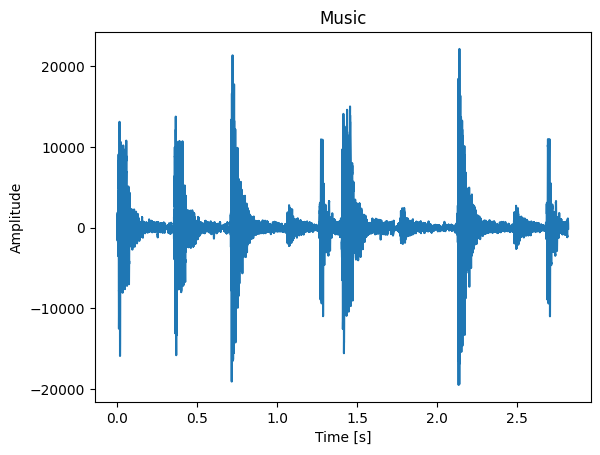

In [29]:
plt.plot(time, canal)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Music')
plt.show()

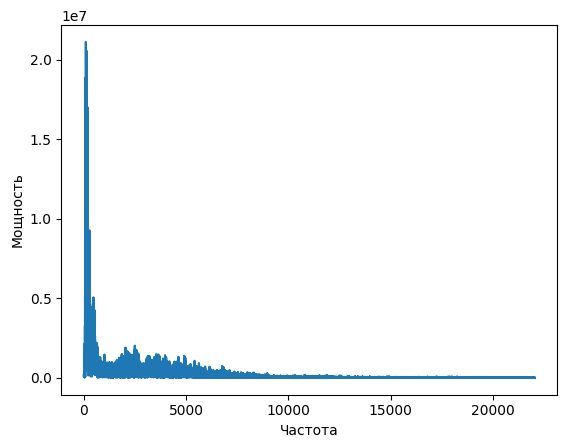

In [30]:
# работаем с 1м каналом

from scipy.fft import  rfft, rfftfreq, irfft


# число точек в normalized_tone
N = int(samplerate * duration)

yf = rfft(canal)
xf = rfftfreq(N, 1 / samplerate)

plt.plot(xf, np.abs(yf))
plt.xlabel('Частота')
plt.ylabel('Мощность')
plt.show()

Применим:
1. Высокочастотный фильтр  (f > 880 Hz)
2. Низкочастотный фильтр    (f < 440 Hz)
3. Полосовой фильтр  (440 < f < 880 )
 

In [31]:
# Максимальная частота составляет половину частоты дискретизации
points_per_freq = len(xf) / (max(xf))

# Наши целевые частоты 
target_idx_hf = int(points_per_freq * 800)
target_idx_lf = int(points_per_freq * 400)

yf_hf = yf.copy()
yf_lf = yf.copy()
yf_pl = yf.copy()
yf_pl_zg = yf.copy()


yf_hf[:target_idx_hf] = 0

yf_lf[target_idx_lf:] = 0

yf_pl[:target_idx_lf] = 0
yf_pl[target_idx_hf:] = 0

yf_pl_zg[target_idx_lf:target_idx_hf] = 0


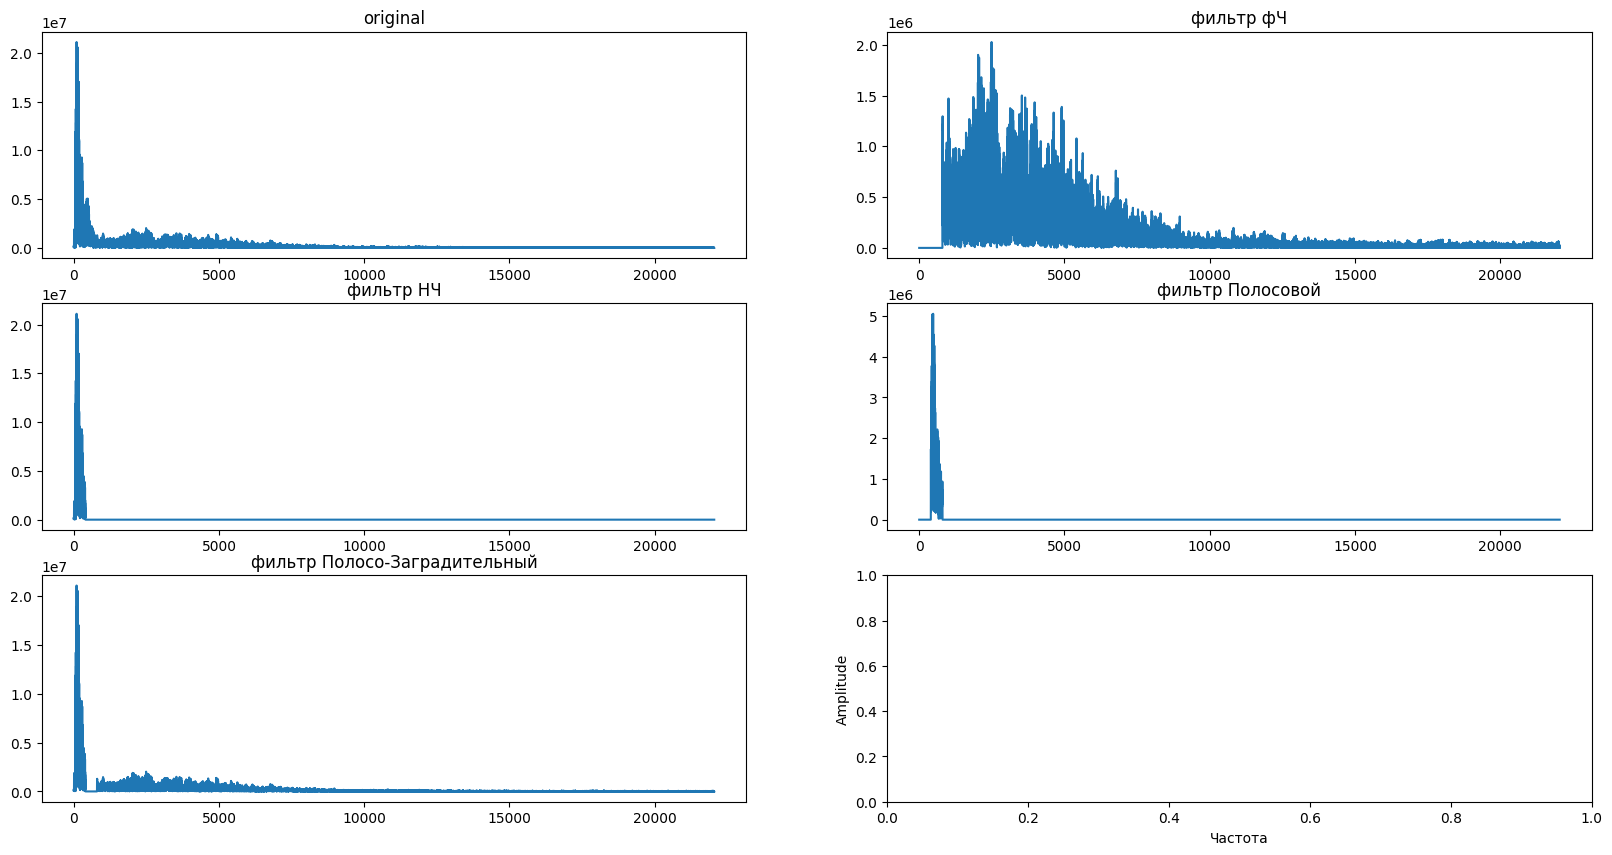

In [33]:
fig, ax = plt.subplots(nrows= 3 , ncols= 2, figsize=(20, 10) )

ax[0,0].plot(xf, np.abs(yf))
ax[0,0].set_title("original")

ax[0,1].plot(xf, np.abs(yf_hf))
ax[0,1].set_title("фильтр фЧ")

ax[1,0].plot(xf, np.abs(yf_lf))
ax[1,0].set_title("фильтр НЧ")

ax[1,1].plot(xf, np.abs(yf_pl))
ax[1,1].set_title("фильтр Полосовой")

ax[2,0].plot(xf, np.abs(yf_pl_zg))
ax[2,0].set_title("фильтр Полосо-Заградительный")


plt.xlabel('Частота')
plt.ylabel('Amplitude')

plt.show()

In [36]:
new_sig_hf = irfft(yf_hf)
new_sig_lf = irfft(yf_lf)
new_sig_pl = irfft(yf_pl)
new_sig_pl_zg = irfft(yf_pl_zg)


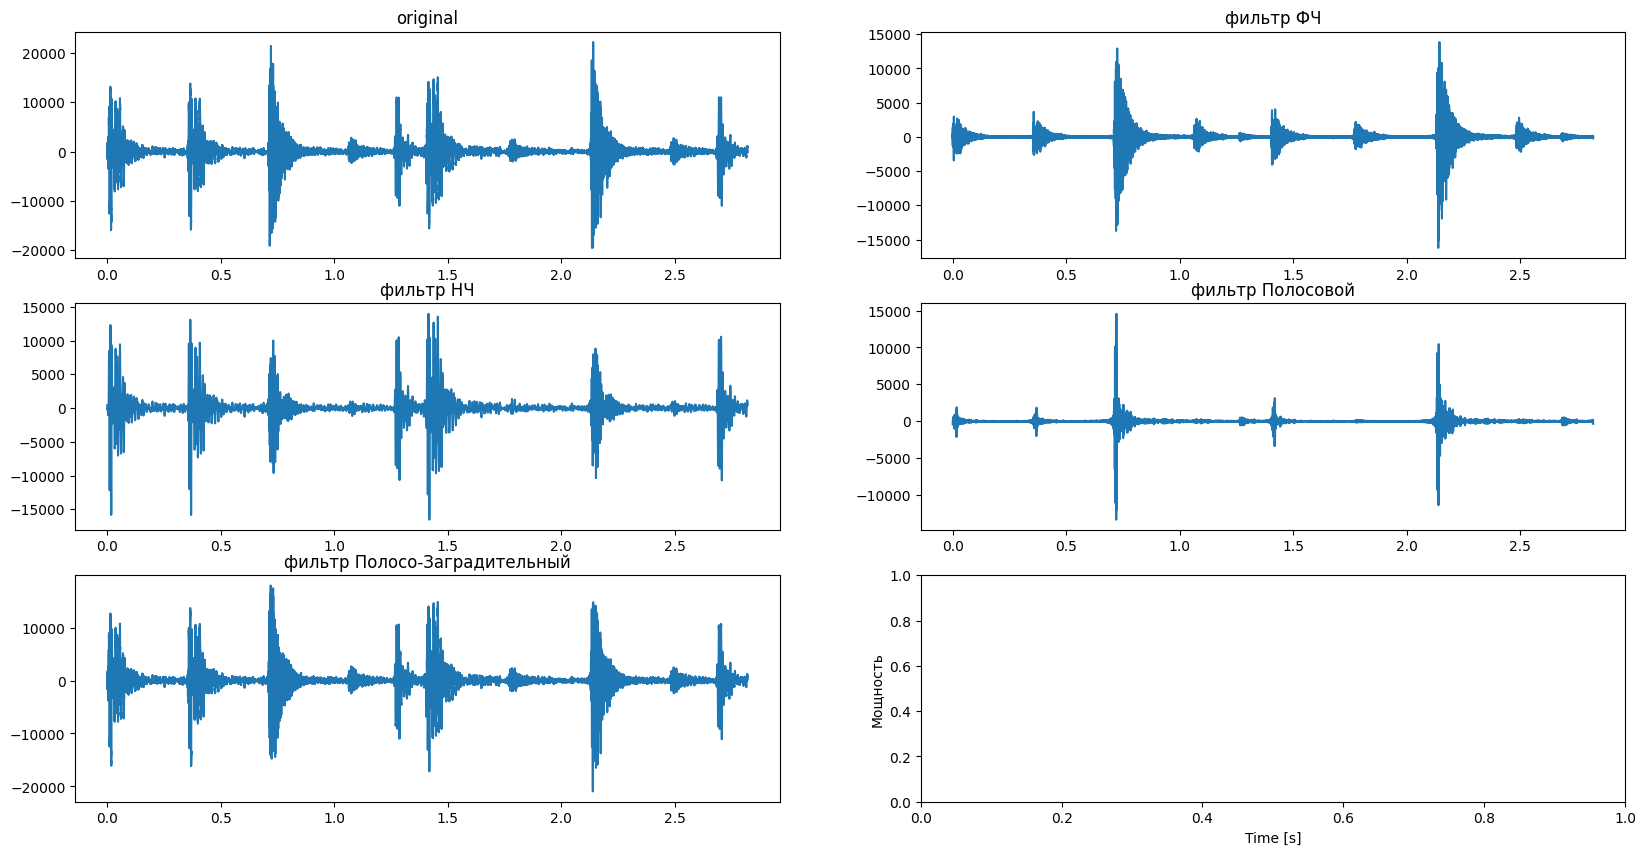

In [37]:
fig, ax = plt.subplots(nrows= 3 , ncols= 2, figsize=(20, 10) )


ax[0,0].plot(time, canal1)
ax[0,0].set_title("original")

ax[0,1].plot(time, new_sig_hf)
ax[0,1].set_title("фильтр ФЧ")

ax[1,0].plot(time, new_sig_lf)
ax[1,0].set_title("фильтр НЧ")

ax[1,1].plot(time, new_sig_pl)
ax[1,1].set_title("фильтр Полосовой")

ax[2,0].plot(time, new_sig_pl_zg)
ax[2,0].set_title("фильтр Полосо-Заградительный")


plt.xlabel('Time [s]')
plt.ylabel('Мощность')

plt.show()

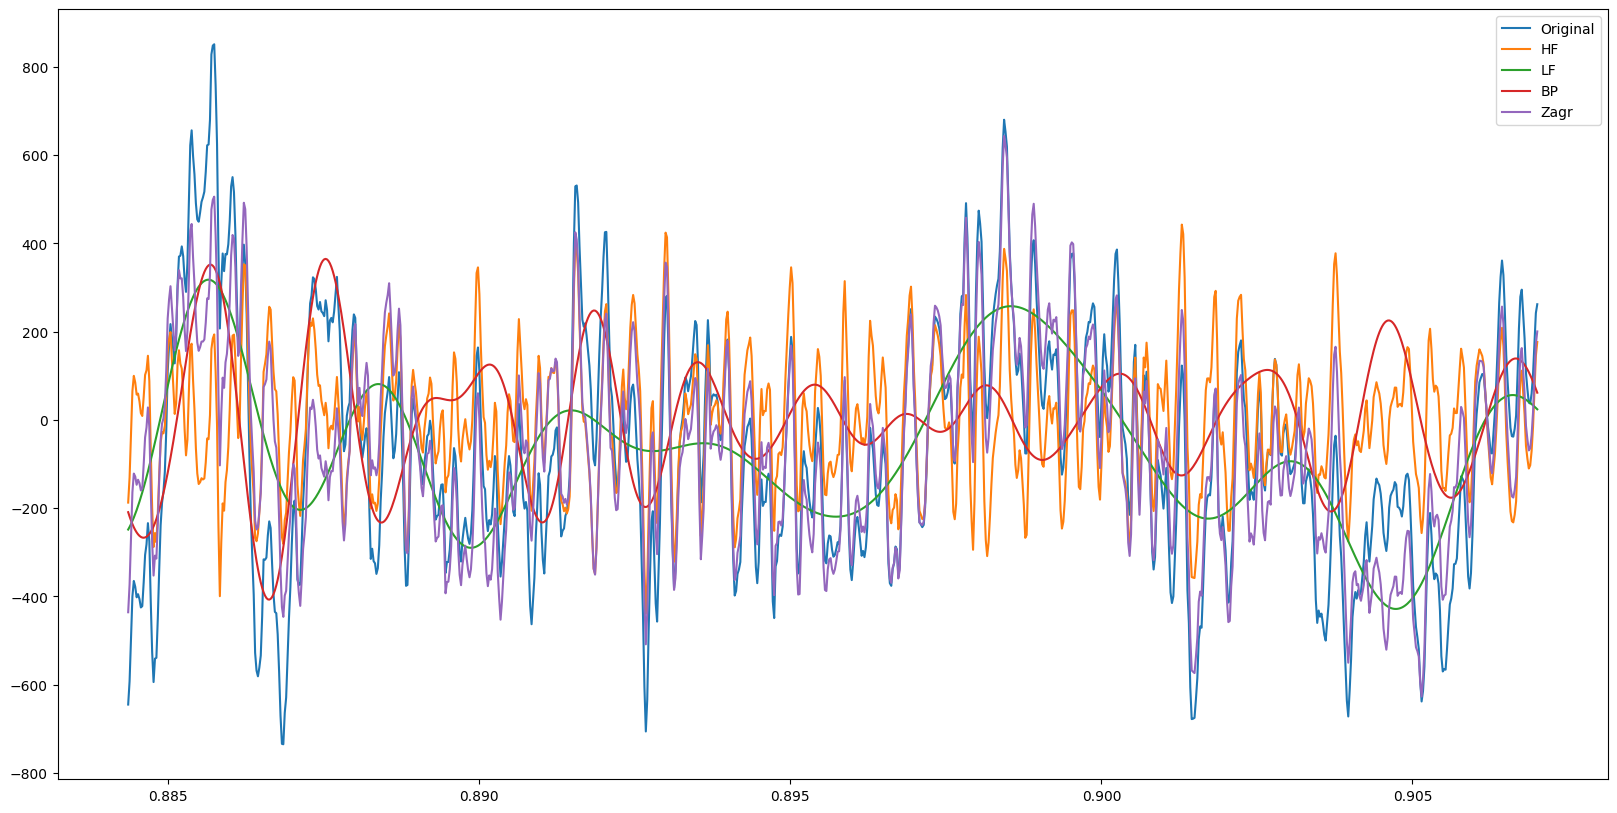

In [38]:
fig, ax = plt.subplots( figsize=(20, 10) )


original, = ax.plot(time[39000:40000], canal[39000:40000], label='Original')
signal_hf, = ax.plot(time[39000:40000], new_sig_hf[39000:40000], label='HF')
signal_lf, = ax.plot(time[39000:40000], new_sig_lf[39000:40000], label='LF')
signal_bp, = ax.plot(time[39000:40000], new_sig_pl[39000:40000], label='BP')
signal_bp_rvs, = ax.plot(time[39000:40000], new_sig_pl_zg[39000:40000], label='Zagr')


ax.legend(handles=[original, signal_hf, signal_lf, signal_bp, signal_bp_rvs])

plt.show()

In [39]:
# НИКОГДА НЕ слушаем, что получилось
sd.play(canal, samplerate)

In [40]:
# НИКОГДА НЕ слушаем, что получилось
sd.play(new_sig_hf, samplerate)
 

In [41]:
# НИКОГДА НЕ слушаем, что получилось
sd.play(new_sig_lf, samplerate, blocking = False)


In [42]:
# НИКОГДА НЕ слушаем, что получилось
sd.play(new_sig_pl, samplerate)
 

In [43]:
# НИКОГДА НЕ слушаем, что получилось
sd.play(new_sig_pl_zg, samplerate)

In [44]:
sd.stop()

In [45]:
def exponential_smoothing(values, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [values[0], values[1]]  # first value is same as series
    
    for n in range(1, len(values)):
        result.append(alpha * result[n] + (1 - alpha) * values[n-1])
    
    return result

In [46]:
def plot_exponential_smoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas

        series - dataset with timestamps
        alphas - list of floats, smoothing parameters

    """
    with plt.style.context("seaborn-v0_8-white"):
        

        plt.figure(figsize=(15, 7))

        plt.plot(series[1], "c", label="Actual")

        for alpha in alphas:
            plt.plot(
                exponential_smoothing(series[1], alpha), label="Alpha {}".format(alpha)
            )

      
        plt.legend(loc="best")
        plt.axis("tight")
        plt.title("Exponential Smoothing")
        plt.grid(True)

In [47]:
def double_exponential_smoothing(values, alpha, beta):
    result = [values[0]]
    for n in range(1, len(values)+1):
        if n == 1:
            level, trend = values[0], values[1] - values[0]
        if n >= len(values): # прогнозируем
            value = values[-1]
        else:
            value = values[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [48]:
def plot_double_exponential_smoothing(signal_part, alphas, betas):
    with plt.style.context('seaborn-v0_8-white'):
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(signal_part[1], alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        print(0)
        plt.plot(signal_part[1], label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

0


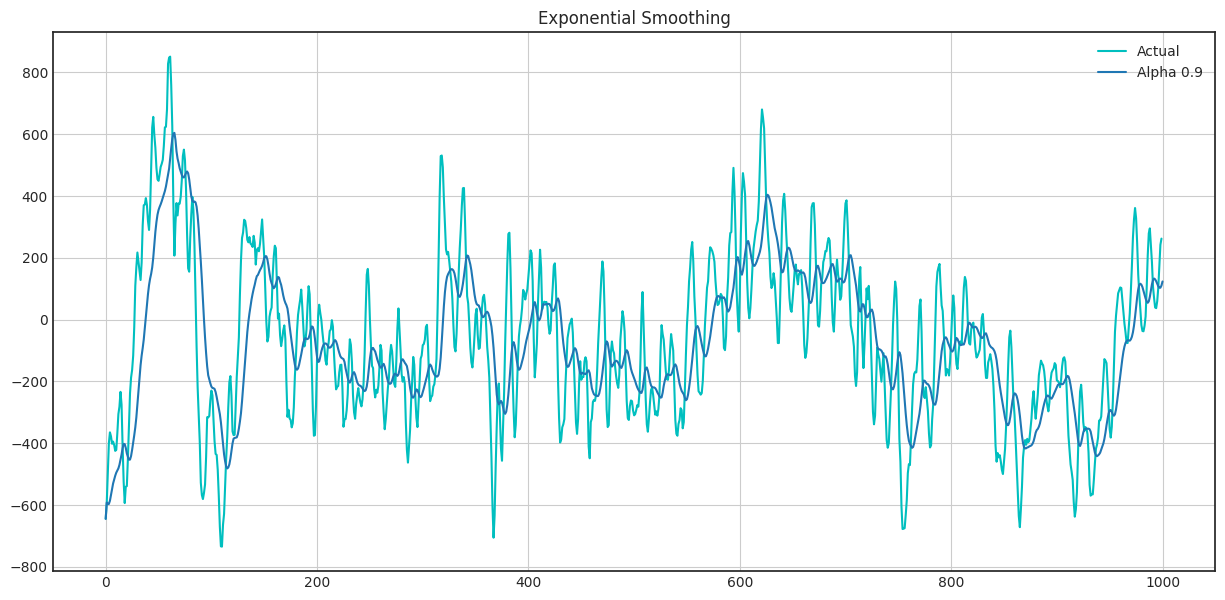

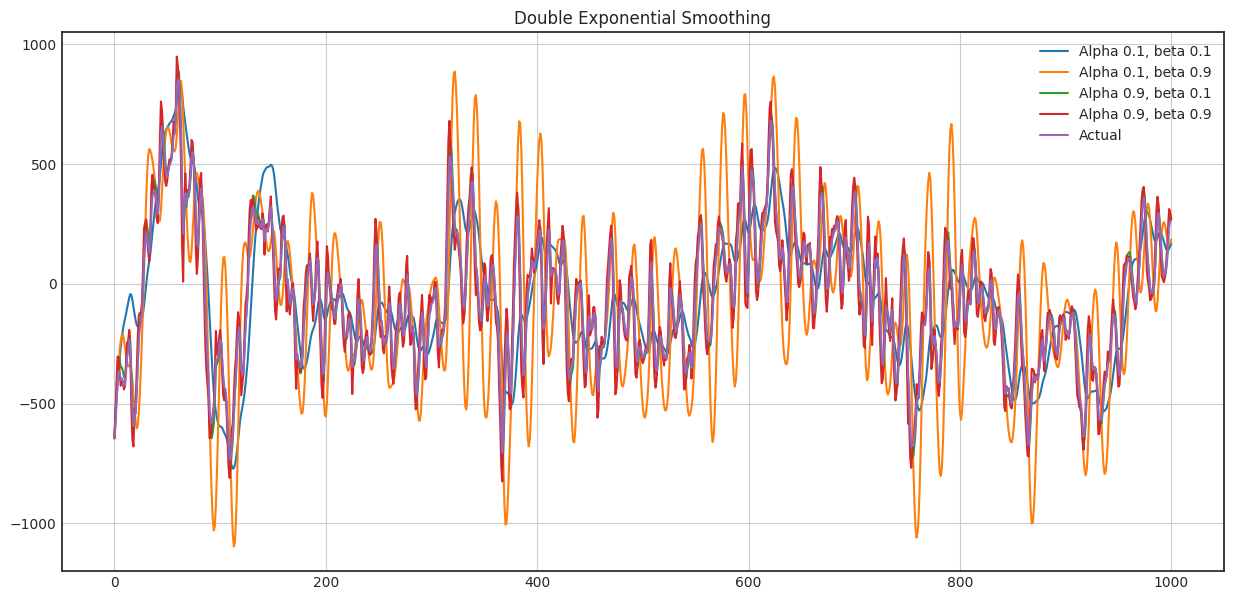

In [49]:
signal_part = canal[39000:40000]
time_part = time[39000:40000]
 
series = pd.Series([time[39000:40000],canal[39000:40000]])  

plot_exponential_smoothing(series, alphas=[0.9])
plot_double_exponential_smoothing(series, alphas=[0.1, 0.9], betas=[0.1, 0.9])

In [50]:
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series) / slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen * j:slen * j + slen]) / float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen * j + i] - season_averages[j]
        seasonals[i] = sum_of_vals_over_avg / n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

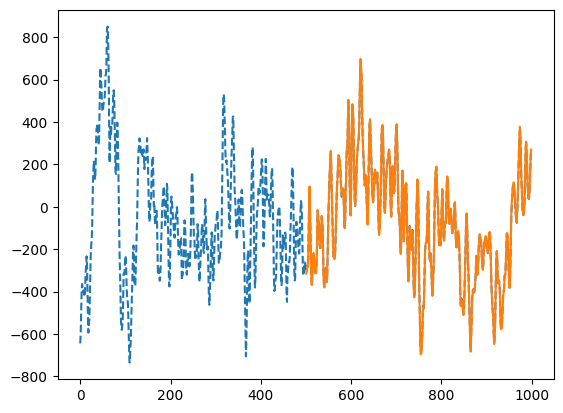

In [52]:
count = 500 #Предсказываем 500 точек
ind = len(signal_part) - count
vals = triple_exponential_smoothing(signal_part, 12, 0.716, 0.029, 0.993, count)
# вырезаем отрезок по x
x = range(ind + count)
x_pr = range(ind, ind + count)
# отрисовываем. Сплошная линия - предсказание.
plt.plot(x[:], signal_part[:], linestyle='dashed')
plt.plot(x_pr, vals[ind:ind+count])

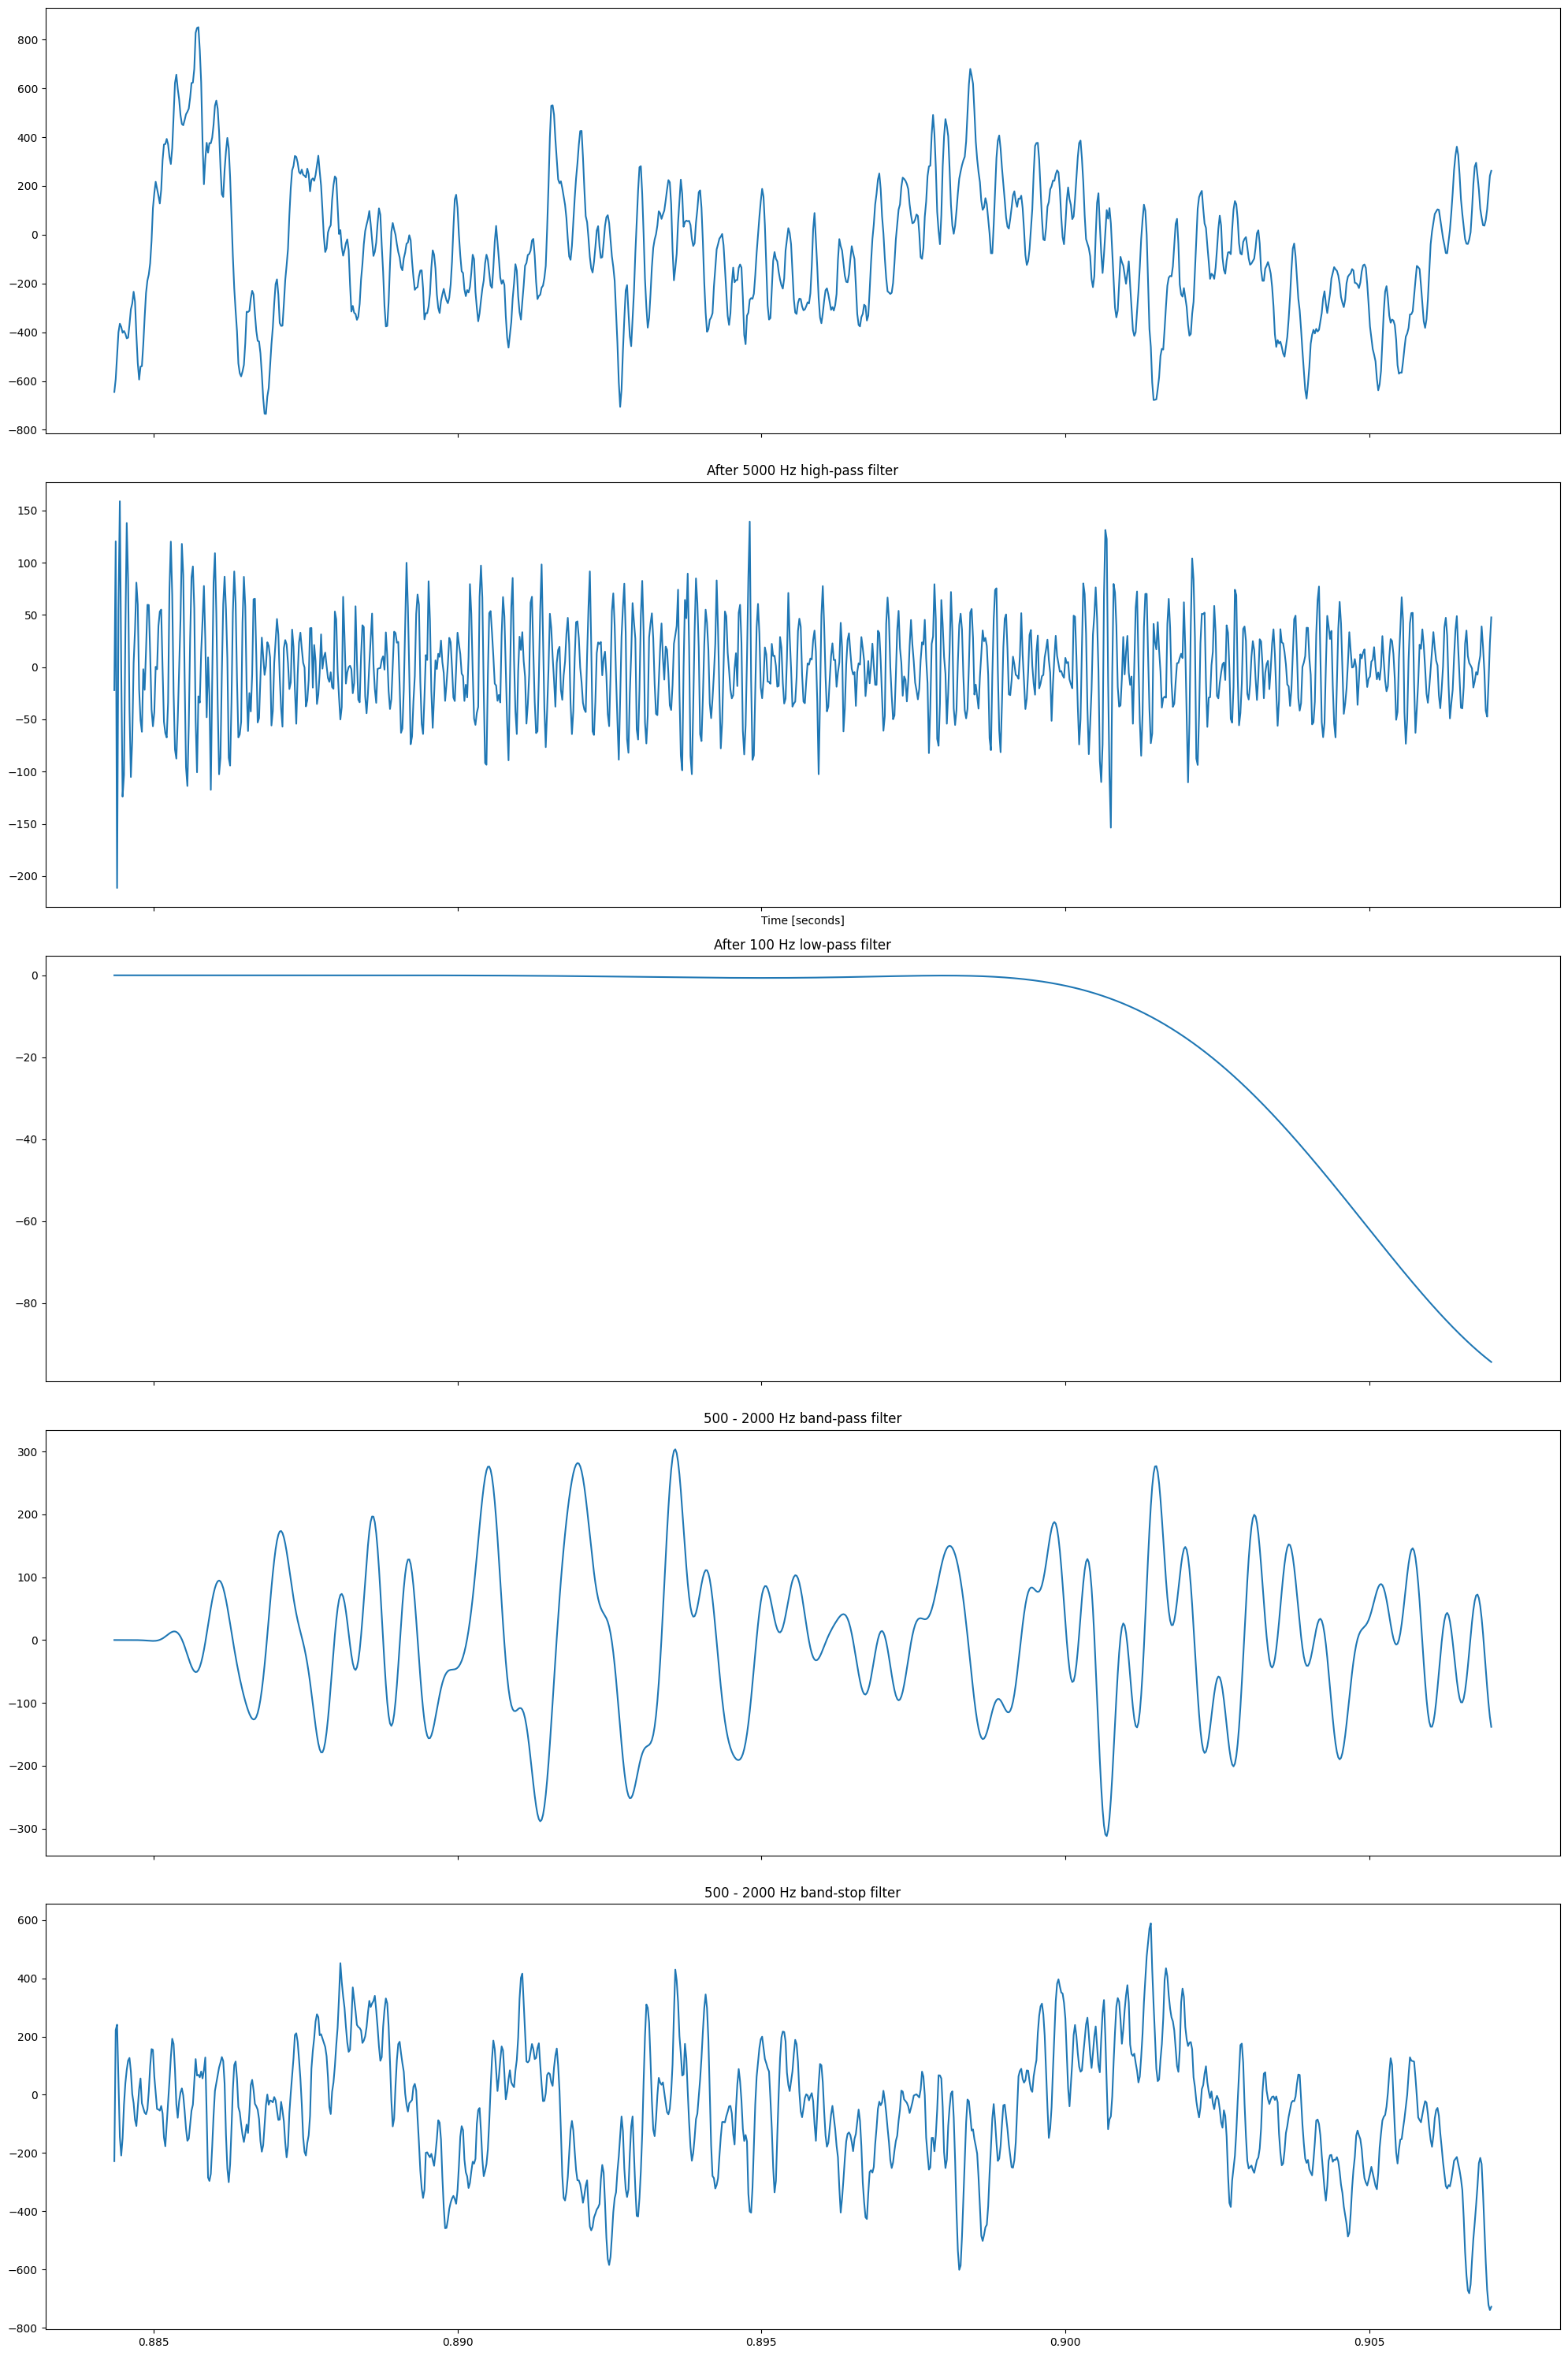

In [53]:

# high pass
sos_hp = signal.cheby1(10, 1, 5000, 'hp', fs=samplerate, output='sos')
filtered_hp = signal.sosfilt(sos_hp, signal_part)


# low pass
sos_lp = signal.cheby1(10, 1, 100, 'lp', fs=samplerate, output='sos')
filtered_lp = signal.sosfilt(sos_lp, signal_part)


# band pass
sos_bp = signal.cheby1(10, 1, [500, 2000], 'bp', fs=samplerate, output='sos')
filtered_bp = signal.sosfilt(sos_bp, signal_part)

# band stop
sos_bs = signal.cheby1(10, 1, [500, 2000], 'bs', fs=samplerate, output='sos')
filtered_bs = signal.sosfilt(sos_bs, signal_part)


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True, figsize=(20,30))
ax1.plot(time_part, signal_part)

ax2.plot(time_part, filtered_hp)
ax2.set_title('After 5000 Hz high-pass filter')

ax3.plot(time_part, filtered_lp)
ax3.set_title('After 100 Hz low-pass filter')

ax4.plot(time_part, filtered_bp)
ax4.set_title('500 - 2000 Hz band-pass filter')
 
ax5.plot(time_part, filtered_bs)
ax5.set_title('500 - 2000 Hz band-stop filter')

ax2.set_xlabel('Time [seconds]')
plt.tight_layout()
plt.show()

In [54]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

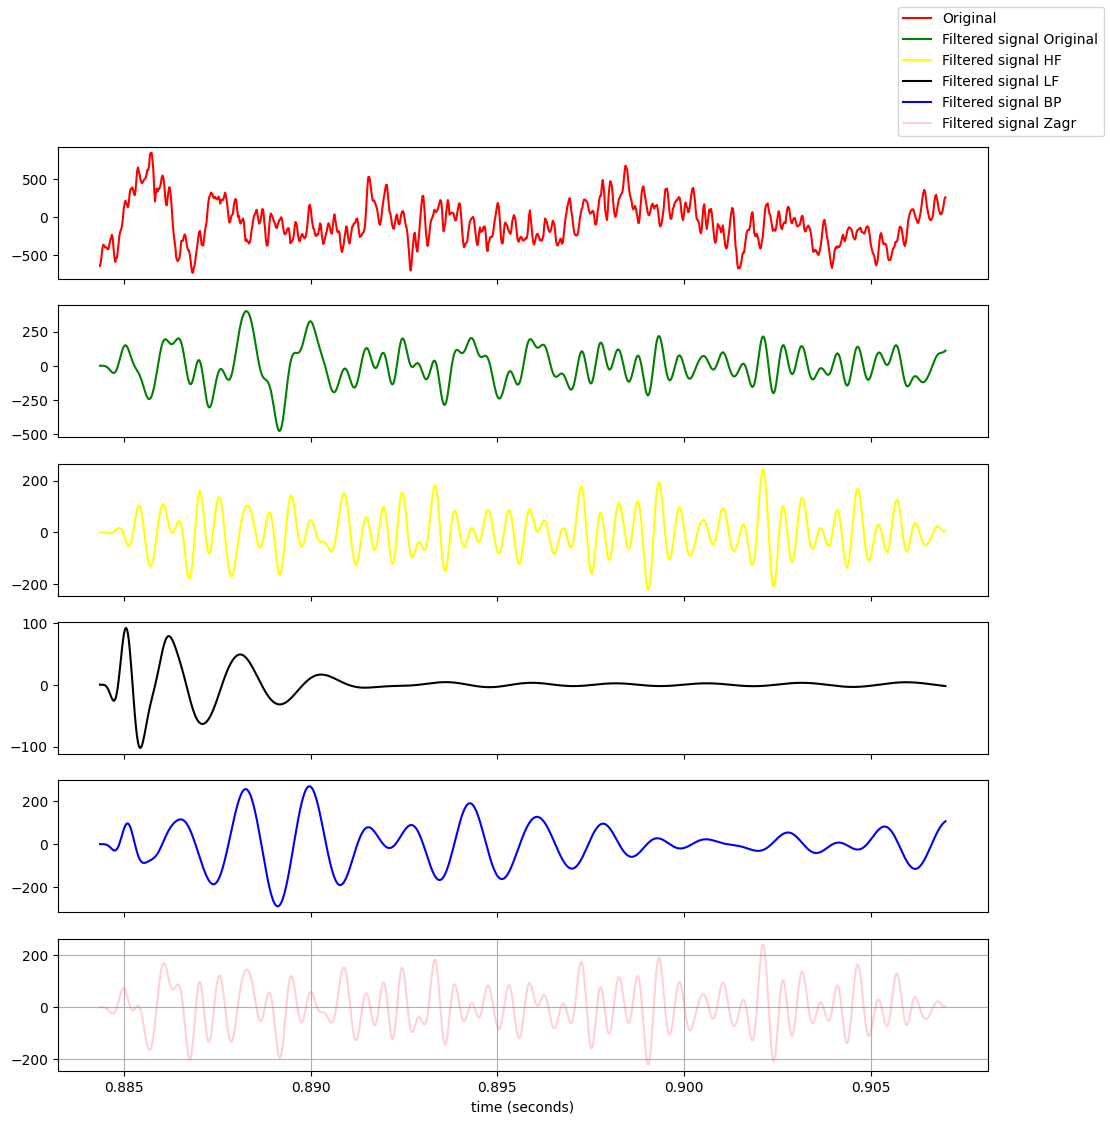

In [74]:
fs = samplerate

lowcut = 500.0
highcut = 2000.0


fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, sharex=True, figsize=(12,12))

ax1.plot(time_part, canal[39000:40000], label='Original', color = 'red')

y2 = butter_bandpass_filter(canal[39000:40000], lowcut, highcut, fs, order=6)
ax2.plot(time_part, y2, label='Filtered signal Original', color = 'green')

y3 = butter_bandpass_filter(new_sig_hf[39000:40000], lowcut, highcut, fs, order=6)
ax3.plot(time_part, y3, label='Filtered signal HF', color = 'yellow')

y4 = butter_bandpass_filter(new_sig_lf[39000:40000], lowcut, highcut, fs, order=6)
ax4.plot(time_part, y4, label='Filtered signal LF', color = 'black')

y5 = butter_bandpass_filter(new_sig_pl[39000:40000], lowcut, highcut, fs, order=6)
ax5.plot(time_part, y5, label='Filtered signal BP', color = 'blue')

y6 = butter_bandpass_filter(new_sig_pl_zg[39000:40000], lowcut, highcut, fs, order=6)
ax6.plot(time_part, y6, label='Filtered signal Zagr', color = '#F564')



plt.xlabel('time (seconds)')
 
plt.grid(True)
plt.axis('tight')
fig.legend(loc='upper right')

plt.show()
